In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import ta  # Technical Analysis Library
import yfinance as yf
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DQN
from stable_baselines3.common.vec_env import DummyVecEnv
from sklearn.metrics import mean_squared_error, mean_absolute_error
from datetime import datetime, timedelta
from tensorflow.keras.callbacks import EarlyStopping

# hide warnings
import warnings
warnings.filterwarnings('ignore')

2024-10-10 10:18:35.175094: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def preprocess_single_pair(data: pd.DataFrame, agg_interval: int) -> pd.DataFrame:
    """
    Preprocesses a single forex pair data.

    Args:
        data (pd.DataFrame): DataFrame containing forex data for a single pair.
        agg_interval (int): The interval for aggregation in minutes.
    
    Returns:
        pd.DataFrame: Preprocessed forex data.
    """

    # Ensure the date column is in datetime format
    #    data['date'] = pd.to_datetime(data['date'])

    # Set the date as the index for resampling
    data.set_index('date', inplace=True)

    # Resample the data to the desired aggregation interval
    resampled_data = data.resample(f'{agg_interval}T').agg({
        'Open': 'first',
        'High': 'max',
        'Low': 'min',
        'Close': 'last',
        'Volume': 'sum'  # Aggregate volume as well
    })

    # Reset the index to get date back as a column
    resampled_data.reset_index(inplace=True)

    return resampled_data


In [3]:
def load_and_preprocess_data(filepath):
    """Load and preprocess data for model training."""
    data = pd.read_csv(filepath, dtype={
        '<DTYYYYMMDD>': str, 
        '<TICKER>': str,
        '<TIME>': str, 
        '<OPEN>': np.float32,
        '<HIGH>': np.float32,
        '<LOW>': np.float32,
        '<CLOSE>': np.float32,
        '<VOL>': np.float32
    })
    data['<DT>'] = pd.to_datetime(data['<DTYYYYMMDD>'] + ' ' + data['<TIME>'])
    data.drop(['<DTYYYYMMDD>', '<TIME>', '<TICKER>'], axis=1, inplace=True)
    data = data[['<DT>'] + [col for col in data.columns if col != '<DT>']]

    # Rename the columns to make them more readable
    data = data.rename(columns={
        '<DT>': 'date',
        '<OPEN>': 'Open',
        '<HIGH>': 'High',
        '<LOW>': 'Low',
        '<CLOSE>': 'Close',
        '<VOL>': 'Volume'
    })
    # Set the datetime column as the index
    # data.set_index("date", inplace=True)
    # Sort the data by date
    # data = data.sort_values(by='date')

    return preprocess_single_pair(data, agg_interval=15)

In [4]:
def download_forex_data(ticker, start_date, end_date, interval='1d', chunk_size=50):
    start_date = datetime.strptime(start_date, '%Y-%m-%d')
    end_date = datetime.strptime(end_date, '%Y-%m-%d')
    
    date_ranges = []
    current_start = start_date
    
    while current_start < end_date:
        current_end = min(current_start + timedelta(days=chunk_size), end_date)
        date_ranges.append((current_start, current_end))
        current_start = current_end + timedelta(days=1)
    
    all_data = pd.DataFrame()
    for start, end in date_ranges:
        data_chunk = yf.download(ticker, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'), interval=interval)
        all_data = pd.concat([all_data, data_chunk])
    
    return all_data

In [5]:
ticker = 'EURUSD=X'  # Forex pair
# data=pd.read_csv("currency_hourly_data.csv", index_col="Unnamed: 0")
data = load_and_preprocess_data('EURUSD.txt')

# Ensure no duplicates and sort by date
data = data[~data.index.duplicated(keep='first')]
data = data.sort_index()
data.index = pd.to_datetime(data.index)  # Convert index to datetime if necessary

In [6]:
# data.set_index('date', inplace=True)
data.head()

,Open,High,Low,Close,Volume
date,,,,,
2001-01-02 23:00:00,0.9507,0.9507,0.9505,0.9507,56.0
2001-01-02 23:15:00,0.9507,0.9507,0.9506,0.9507,28.0
2001-01-02 23:30:00,0.9507,0.9509,0.9507,0.9508,40.0
2001-01-02 23:45:00,0.9508,0.9508,0.9506,0.9506,52.0
2001-01-03 00:00:00,0.9506,0.9507,0.9505,0.9506,56.0


In [7]:
# remove the data with zero values
data = data[(data != 0).all(axis=1)]

In [8]:
len(data)

581245

In [9]:
# Feature Engineering
def add_technical_indicators(df):
    """
    Add various technical indicators to the DataFrame for improved forecasting with an LSTM model.

    Parameters:
    df (DataFrame): The input DataFrame containing price data.

    Returns:
    DataFrame: The DataFrame with added technical indicators.
    """
    
    # Short-term Simple Moving Average
    df['SMA_short'] = df['Close'].rolling(window=20).mean()
    
    # Long-term Simple Moving Average
    df['SMA_long'] = df['Close'].rolling(window=50).mean()
    
    # Exponential Moving Average for responsiveness to recent price changes
    df['EMA'] = ta.trend.ema_indicator(df['Close'], window=20)
    
    # Relative Strength Index for momentum measurement
    df['RSI'] = ta.momentum.rsi(df['Close'], window=14)
    
    # Bollinger Bands to measure volatility
    df['Bollinger_High'] = ta.volatility.bollinger_hband(df['Close'])
    df['Bollinger_Low'] = ta.volatility.bollinger_lband(df['Close'])
    
    # Moving Average Convergence Divergence (MACD) for trend direction
    df['MACD'] = ta.trend.macd(df['Close'])
    
    # Daily returns to capture price changes
    df['returns'] = df['Close'].pct_change()
    
    # Volatility as a measure of risk
    df['volatility'] = df['returns'].rolling(window=20).std()
    
    # Momentum indicator to capture the strength of price trends
    df['momentum'] = df['Close'] / df['Close'].shift(20) - 1
    
    return df

# Add technical indicators to the data
data = add_technical_indicators(data)

# Replace infinite values with NaN
data = data.replace((np.inf, -np.inf), np.nan)

# Handling missing values using mean imputation
imputer = SimpleImputer(strategy='mean')
data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

# Normalizing data for LSTM model compatibility
scaler = StandardScaler()
data_normalized = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data.columns)


In [10]:
import pandas as pd
import numpy as np
import ta
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer


def engineer_forex_features(df, include_time_features=True):
    """
    Comprehensive feature engineering for forex trading.

    Parameters:
    df (DataFrame): DataFrame with columns: 'Open', 'High', 'Low', 'Close', 'Volume'
    include_time_features (bool): Whether to include time-based features

    Returns:
    DataFrame: Enhanced DataFrame with engineered features
    """
    # Create a copy to avoid modifying the original dataframe
    data = df.copy()

    # 1. Price Action Features
    data["HL_Diff"] = data["High"] - data["Low"]  # High-Low difference
    data["OC_Diff"] = data["Open"] - data["Close"]  # Open-Close difference
    data["HL_Pct"] = (data["High"] - data["Low"]) / data["Low"]  # High-Low percentage

    # 2. Multiple Timeframe Features
    for window in [5, 20, 50, 200]:
        # Simple Moving Averages
        data[f"SMA_{window}"] = ta.trend.sma_indicator(data["Close"], window=window)

        # Exponential Moving Averages
        data[f"EMA_{window}"] = ta.trend.ema_indicator(data["Close"], window=window)

        # Standard Deviation for volatility
        data[f"STD_{window}"] = data["Close"].rolling(window=window).std()

        # Price change over different timeframes
        data[f"Price_Change_{window}"] = data["Close"].pct_change(periods=window)

    # 3. Advanced Technical Indicators
    # Momentum Indicators
    data["RSI"] = ta.momentum.rsi(data["Close"], window=14)
    data["Stoch_K"] = ta.momentum.stoch(
        data["High"], data["Low"], data["Close"], window=14
    )
    data["Stoch_D"] = ta.momentum.stoch_signal(
        data["High"], data["Low"], data["Close"], window=14
    )
    data["ADX"] = ta.trend.adx(data["High"], data["Low"], data["Close"], window=14)

    # Volatility Indicators
    bb_indicator = ta.volatility.BollingerBands(data["Close"])
    data["BB_Upper"] = bb_indicator.bollinger_hband()
    data["BB_Lower"] = bb_indicator.bollinger_lband()
    data["BB_Width"] = (data["BB_Upper"] - data["BB_Lower"]) / data["Close"]
    data["ATR"] = ta.volatility.average_true_range(
        data["High"], data["Low"], data["Close"]
    )

    # Trend Indicators
    macd = ta.trend.MACD(data["Close"])
    data["MACD_Line"] = macd.macd()
    data["MACD_Signal"] = macd.macd_signal()
    data["MACD_Hist"] = data["MACD_Line"] - data["MACD_Signal"]

    # 4. Custom Forex-Specific Features
    # Pip movement features
    pip_multiplier = 100
    data["Pip_Move"] = (data["High"] - data["Low"]) * pip_multiplier
    data["Pip_Move_MA"] = data["Pip_Move"].rolling(window=20).mean()

    # Relative strength across timeframes
    for fast, slow in [(5, 20), (20, 50), (50, 200)]:
        data[f"RS_{fast}_{slow}"] = data[f"SMA_{fast}"] / data[f"SMA_{slow}"]

    # 5. Time-based features if requested
    if include_time_features:
        data["Hour"] = data.index.hour
        data["DayOfWeek"] = data.index.dayofweek

        # Session indicators (assuming GMT)
        data["Tokyo_Session"] = ((data.index.hour >= 0) & (data.index.hour < 9)).astype(
            int
        )
        data["London_Session"] = (
            (data.index.hour >= 8) & (data.index.hour < 17)
        ).astype(int)
        data["NY_Session"] = ((data.index.hour >= 13) & (data.index.hour < 22)).astype(
            int
        )

    return data


def prepare_data_for_model(data, target_cols=["Close"]):
    """
    Prepare the engineered features for the model.

    Parameters:
    data (DataFrame): DataFrame with engineered features
    target_cols (list): List of column names to be used as targets

    Returns:
    tuple: (Processed DataFrame, target DataFrame, scaler objects)
    """
    # Separate features and target
    target_data = data[target_cols].copy()
    feature_data = data.drop(
        columns=(
            ["Open", "High", "Low", "Close", "Volume"]
            if "Volume" in data.columns
            else ["Open", "High", "Low", "Close"]
        )
    )

    # Handle missing values
    feature_imputer = SimpleImputer(strategy="mean")
    target_imputer = SimpleImputer(strategy="mean")

    # Fit and transform feature data
    feature_data_imputed = pd.DataFrame(
        feature_imputer.fit_transform(feature_data),
        columns=feature_data.columns,
        index=feature_data.index,
    )

    # Fit and transform target data
    target_data_imputed = pd.DataFrame(
        target_imputer.fit_transform(target_data),
        columns=target_data.columns,
        index=target_data.index,
    )

    # Scale the data
    feature_scaler = RobustScaler()  # RobustScaler is often better for financial data
    target_scaler = RobustScaler()

    feature_data_scaled = pd.DataFrame(
        feature_scaler.fit_transform(feature_data_imputed),
        columns=feature_data_imputed.columns,
        index=feature_data_imputed.index,
    )

    target_data_scaled = pd.DataFrame(
        target_scaler.fit_transform(target_data_imputed),
        columns=target_data_imputed.columns,
        index=target_data_imputed.index,
    )

    return (
        feature_data_scaled,
        target_data_scaled,
        (feature_scaler, target_scaler, feature_imputer, target_imputer),
    )


# Example of how to use these functions
if __name__ == "__main__":
    # Engineer features
    engineered_data = engineer_forex_features(data)

    # Prepare data for the model
    # feature_data, target_data, scalers = prepare_data_for_model(engineered_data)

    # Create sequences
    # X, y = create_training_sequences(feature_data, target_data)

    # print("Features added:", [col for col in feature_data.columns])

In [11]:
engineered_data.head()

,Open,High,Low,Close,Volume,SMA_short,SMA_long,EMA,RSI,Bollinger_High,...,Pip_Move,Pip_Move_MA,RS_5_20,RS_20_50,RS_50_200,Hour,DayOfWeek,Tokyo_Session,London_Session,NY_Session
date,,,,,,,,,,,,,,,,,,,,,
2001-01-02 23:00:00,0.9507,0.9507,0.9505,0.9507,56.0,NaN,NaN,NaN,NaN,NaN,...,0.019997,NaN,NaN,NaN,NaN,23,1,0,0,0
2001-01-02 23:15:00,0.9507,0.9507,0.9506,0.9507,28.0,NaN,NaN,NaN,NaN,NaN,...,0.009996,NaN,NaN,NaN,NaN,23,1,0,0,0
2001-01-02 23:30:00,0.9507,0.9509,0.9507,0.9508,40.0,NaN,NaN,NaN,NaN,NaN,...,0.020003,NaN,NaN,NaN,NaN,23,1,0,0,0
2001-01-02 23:45:00,0.9508,0.9508,0.9506,0.9506,52.0,NaN,NaN,NaN,NaN,NaN,...,0.019997,NaN,NaN,NaN,NaN,23,1,0,0,0
2001-01-03 00:00:00,0.9506,0.9507,0.9505,0.9506,56.0,NaN,NaN,NaN,NaN,NaN,...,0.019997,NaN,NaN,NaN,NaN,0,2,1,0,0


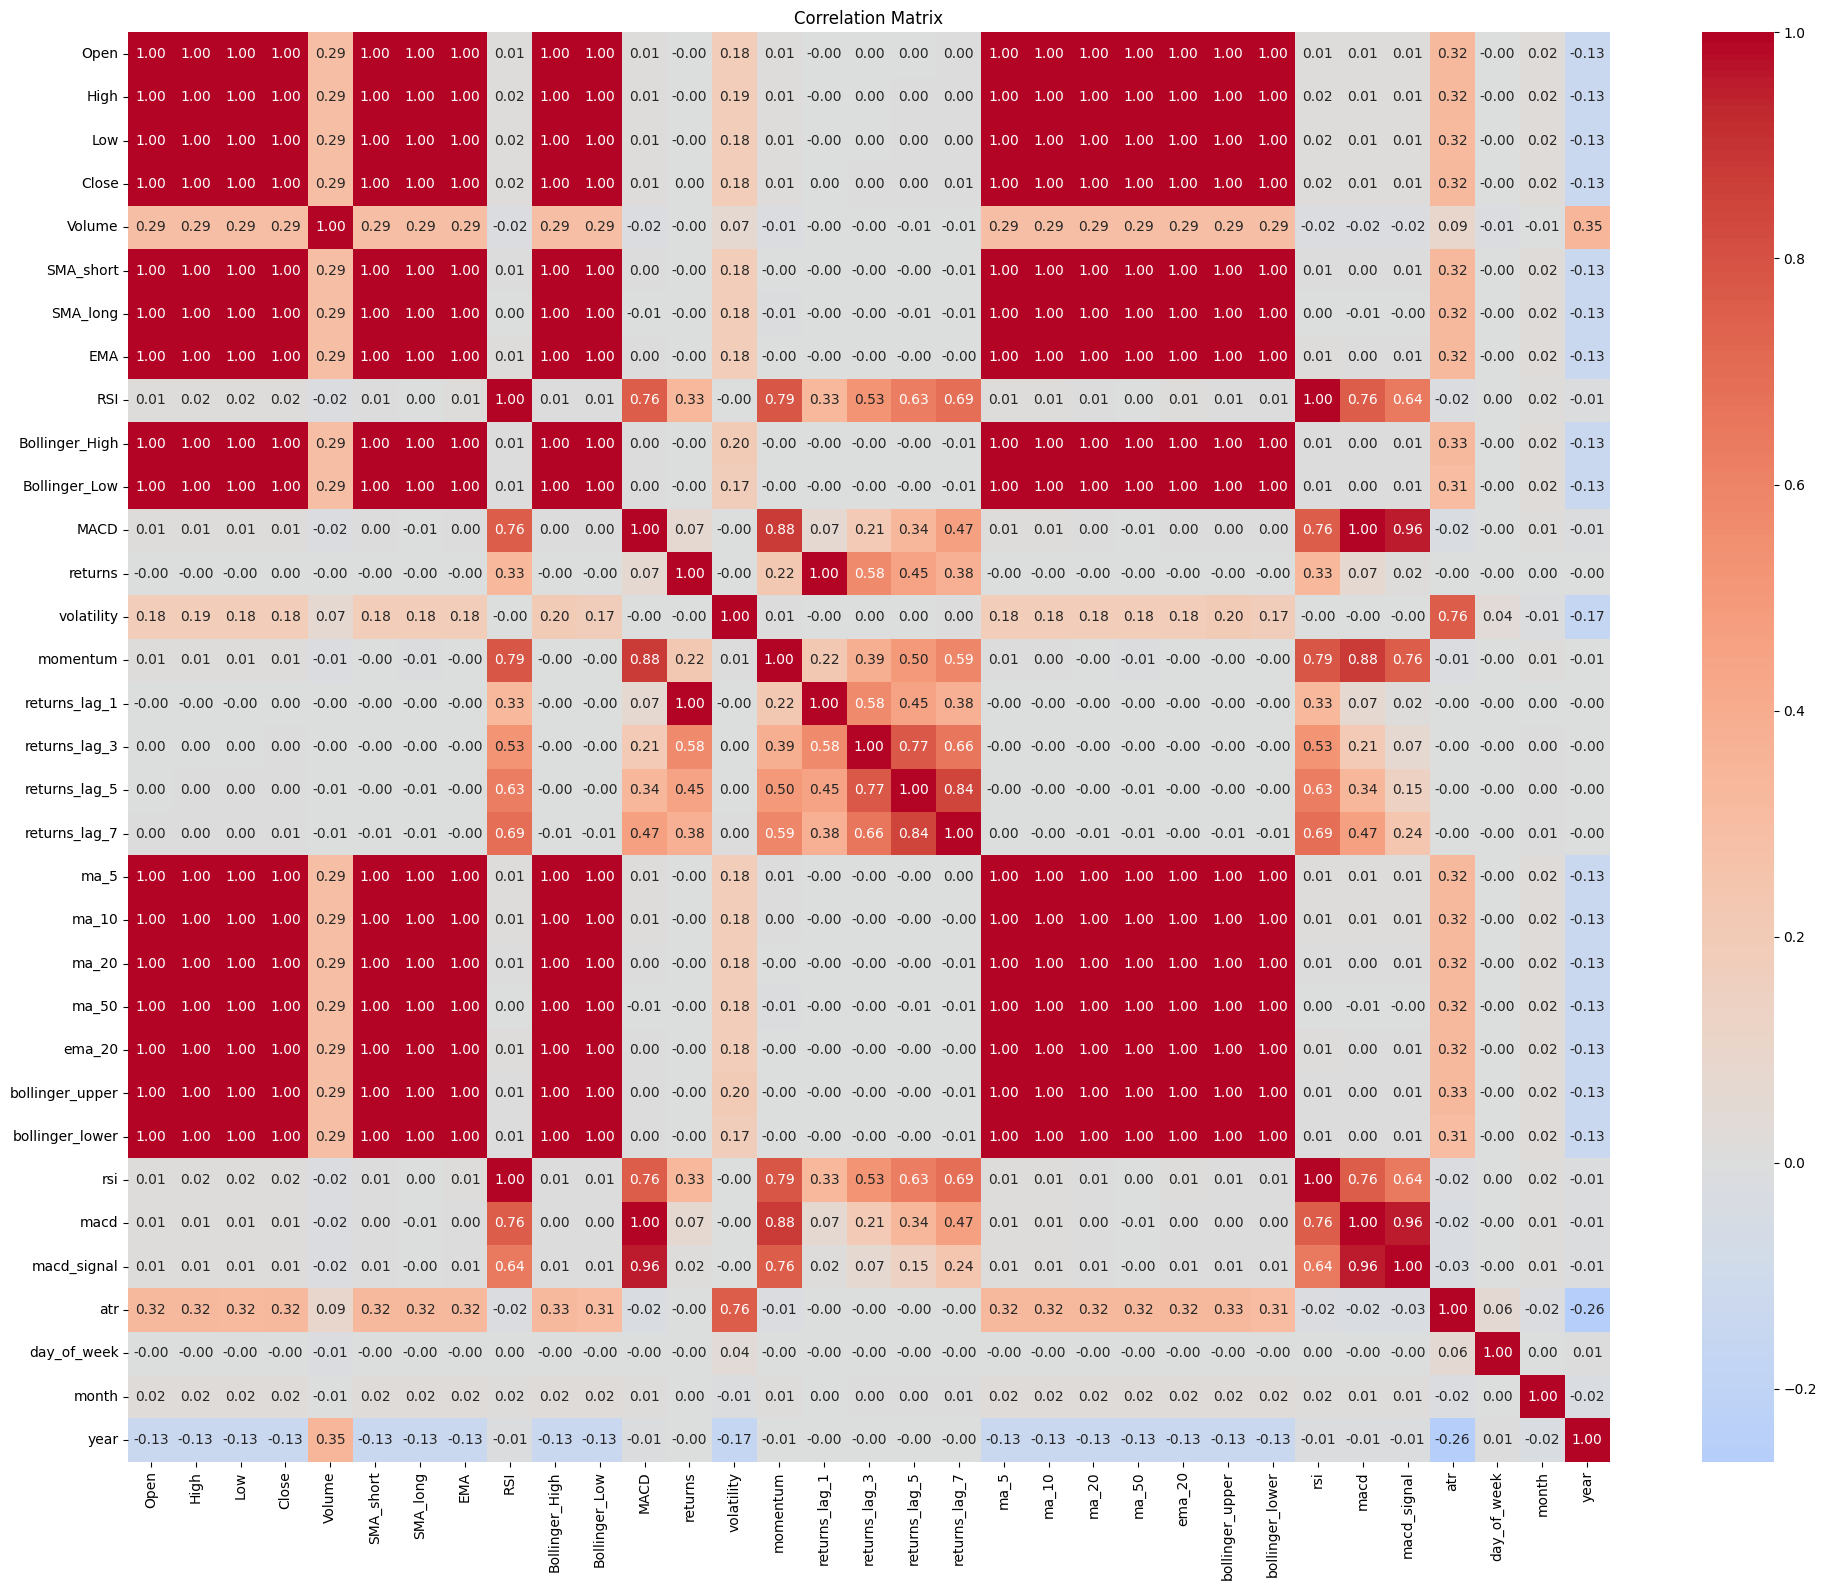

Selected Features: ['Open', 'returns', 'returns_lag_3', 'returns_lag_5', 'returns_lag_7', 'year', 'month', 'RSI', 'atr', 'volatility', 'Volume', 'MACD', 'day_of_week']


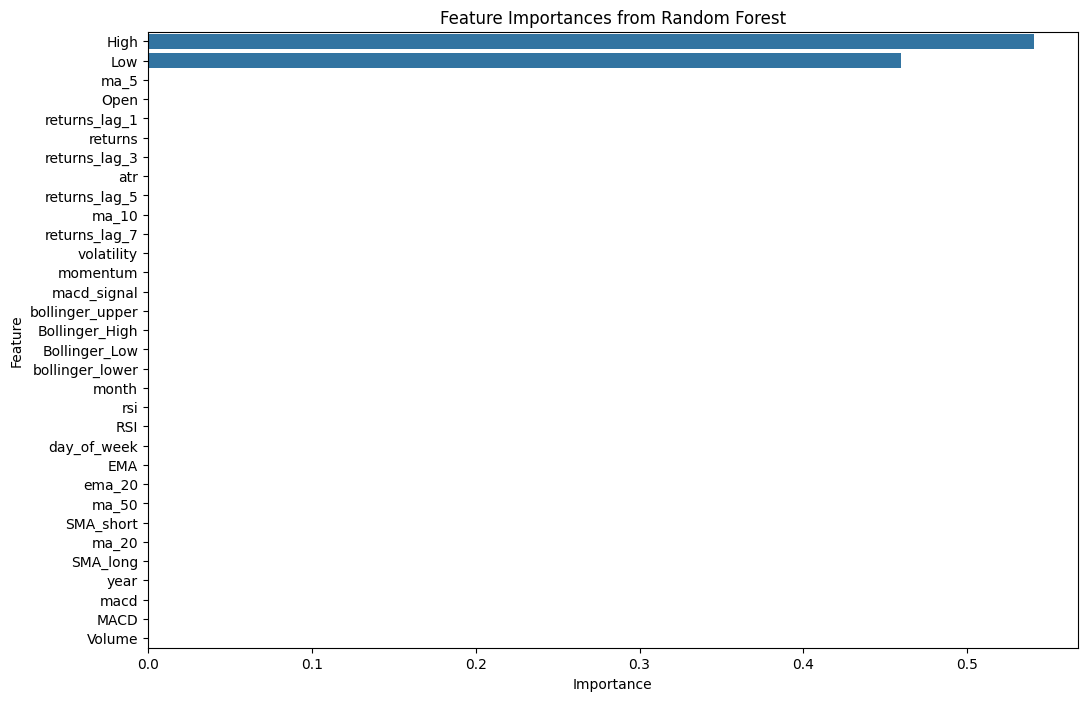

In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import train_test_split
import ta  # Technical Analysis library


def feature_engineering(data):
    """Main feature engineering function."""
    engineered_data = data.copy()

    # Price-Based Features
    for lag in [1, 3, 5, 7]:
        engineered_data[f"returns_lag_{lag}"] = engineered_data["Close"].pct_change(lag)

    # Moving Averages
    for window in [5, 10, 20, 50]:
        engineered_data[f"ma_{window}"] = ta.trend.sma_indicator(
            engineered_data["Close"], window
        )

    # Exponential Moving Average
    engineered_data["ema_20"] = ta.trend.ema_indicator(
        engineered_data["Close"], window=20
    )

    # Volatility Features
    engineered_data["volatility"] = ta.volatility.bollinger_hband(
        engineered_data["Close"]
    ) - ta.volatility.bollinger_lband(engineered_data["Close"])

    # Bollinger Bands
    engineered_data["bollinger_upper"] = ta.volatility.bollinger_hband(
        engineered_data["Close"], window=20, window_dev=2
    )
    engineered_data["bollinger_lower"] = ta.volatility.bollinger_lband(
        engineered_data["Close"], window=20, window_dev=2
    )

    # RSI
    engineered_data["rsi"] = ta.momentum.rsi(engineered_data["Close"], window=14)

    # MACD
    engineered_data["macd"] = ta.trend.macd(engineered_data["Close"])
    engineered_data["macd_signal"] = ta.trend.macd_signal(engineered_data["Close"])

    # Average True Range (ATR)
    engineered_data["atr"] = ta.volatility.average_true_range(
        engineered_data["High"],
        engineered_data["Low"],
        engineered_data["Close"],
        window=14,
    )

    # Time-Based Features
    engineered_data["day_of_week"] = engineered_data.index.dayofweek
    engineered_data["month"] = engineered_data.index.month
    engineered_data["year"] = engineered_data.index.year

    # Drop any rows with NaN values generated from the feature calculations
    engineered_data.dropna(inplace=True)

    return engineered_data


def analyze_correlations(engineered_data, target_col):
    """Analyze and visualize the correlation matrix."""
    correlation_matrix = engineered_data.corr()
    plt.figure(figsize=(20, 16))
    sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", center=0)
    plt.title("Correlation Matrix")
    plt.tight_layout()
    plt.show()

    return correlation_matrix


def calculate_mutual_information(engineered_data, target_col):
    """Calculate mutual information scores."""
    X = engineered_data.drop(columns=[target_col])
    y = engineered_data[target_col]

    mi_scores = mutual_info_regression(X, y)
    mi_scores = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

    return mi_scores


def select_relevant_features(correlation_matrix, mi_scores, correlation_threshold=0.85):
    """Select features based on correlation and mutual information."""
    correlated_features = set()
    for i in range(len(correlation_matrix.columns)):
        for j in range(i):
            if abs(correlation_matrix.iloc[i, j]) > correlation_threshold:
                colname = correlation_matrix.columns[i]
                correlated_features.add(colname)

    selected_features = [
        col for col in mi_scores.index if col not in correlated_features
    ]

    return selected_features


def feature_importance_analysis(engineered_data, target_col):
    """Perform feature importance analysis using Random Forest."""
    X = engineered_data.drop(columns=[target_col])
    y = engineered_data[target_col]

    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42
    )

    # Train a Random Forest Regressor
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    # Get feature importances
    feature_importances = model.feature_importances_
    feature_importance_df = pd.DataFrame(
        {"Feature": X.columns, "Importance": feature_importances}
    ).sort_values(by="Importance", ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 8))
    sns.barplot(x="Importance", y="Feature", data=feature_importance_df)
    plt.title("Feature Importances from Random Forest")
    plt.show()

    return feature_importance_df


# Example usage
if __name__ == "__main__":

    # Generate features
    engineered_data = feature_engineering(data)
    # Handling missing values using mean imputation
    imputer = SimpleImputer(strategy="mean")
    data_imputed = pd.DataFrame(
        imputer.fit_transform(engineered_data), columns=engineered_data.columns
    )
    # Normalizing data for LSTM model compatibility
    scaler = StandardScaler()
    data_normalized = pd.DataFrame(
        scaler.fit_transform(data_imputed), columns=engineered_data.columns
    )
    # Analyze correlations
    target_col = "Close"  # Replace with your actual target column
    correlation_matrix = analyze_correlations(data_normalized, target_col)

    # Calculate mutual information scores
    mi_scores = calculate_mutual_information(data_normalized, target_col)

    # Select relevant features
    selected_features = select_relevant_features(correlation_matrix, mi_scores)

    print("Selected Features:", selected_features)

    # Perform feature importance analysis
    feature_importance_df = feature_importance_analysis(data_normalized, target_col)

In [13]:
def create_sequences(data, seq_length, prediction_length):
    xs, ys, timestamps = [], [], []
    for i in range(len(data) - seq_length - prediction_length):
        x = data.iloc[i:i + seq_length].values
        y = data.iloc[i + seq_length:i + seq_length + prediction_length]['Close'].values
        timestamp_seq = data.index[i:i + seq_length].to_list()  # Extract timestamps from the index
        xs.append(x)
        ys.append(y)
        timestamps.append(timestamp_seq)
    return np.array(xs), np.array(ys), timestamps

In [14]:
# use the engineered data to create sequences for the LSTM model
training_data = data_normalized[selected_features + [target_col]]

In [15]:
# Define the sequence length and prediction length
SEQ_LENGTH = 50
PRED_LENGTH = 5

# Create sequences for LSTM model
X, y, timestamps = create_sequences(data_normalized, SEQ_LENGTH, PRED_LENGTH)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Building the LSTM Model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(SEQ_LENGTH, X_train.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(PRED_LENGTH))  # Output single value for Close price

model.compile(optimizer='adam', loss='mse')

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=20, verbose=1, mode='min', restore_best_weights=True)

# Train the model with EarlyStopping
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


#  save the model
model.save('lstm_model.h5')
model.summary()

Epoch 1/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 588s 40ms/step - loss: 0.0205 - val_loss: 0.0010
Epoch 2/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 558s 38ms/step - loss: 0.0070 - val_loss: 7.9113e-04
Epoch 3/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 562s 39ms/step - loss: 0.0067 - val_loss: 0.0019
Epoch 4/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 544s 37ms/step - loss: 0.0065 - val_loss: 1.2690e-04
Epoch 5/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 566s 39ms/step - loss: 0.0065 - val_loss: 8.3513e-04
Epoch 6/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 584s 40ms/step - loss: 0.0063 - val_loss: 2.1360e-04
Epoch 7/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 587s 40ms/step - loss: 0.0063 - val_loss: 5.3266e-04
Epoch 8/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 643s 44ms/step - loss: 0.0063 - val_loss: 3.1232e-04
Epoch 9/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 614s 42ms/step - loss: 0.0062 - val_loss: 0.0033
Epoch 10/100
14529/14529 ━━━━━━━━━━━━━━━━━━━━ 634s 44ms/step - loss: 0.0063 - val_loss: 3.7608e-04
Epoch 11/100
14529/14529 ━━━━━━

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50, 50)         │        16,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 5)              │           255 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 111,767 (436.59 KB)

 Trainable params: 37,255 (145.53 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 74,512 (291.07 KB)

3633/3633 ━━━━━━━━━━━━━━━━━━━━ 44s 11ms/step
Mean Squared Error: 0.00012689639680484526
Mean Absolute Error: 0.007990209386720733


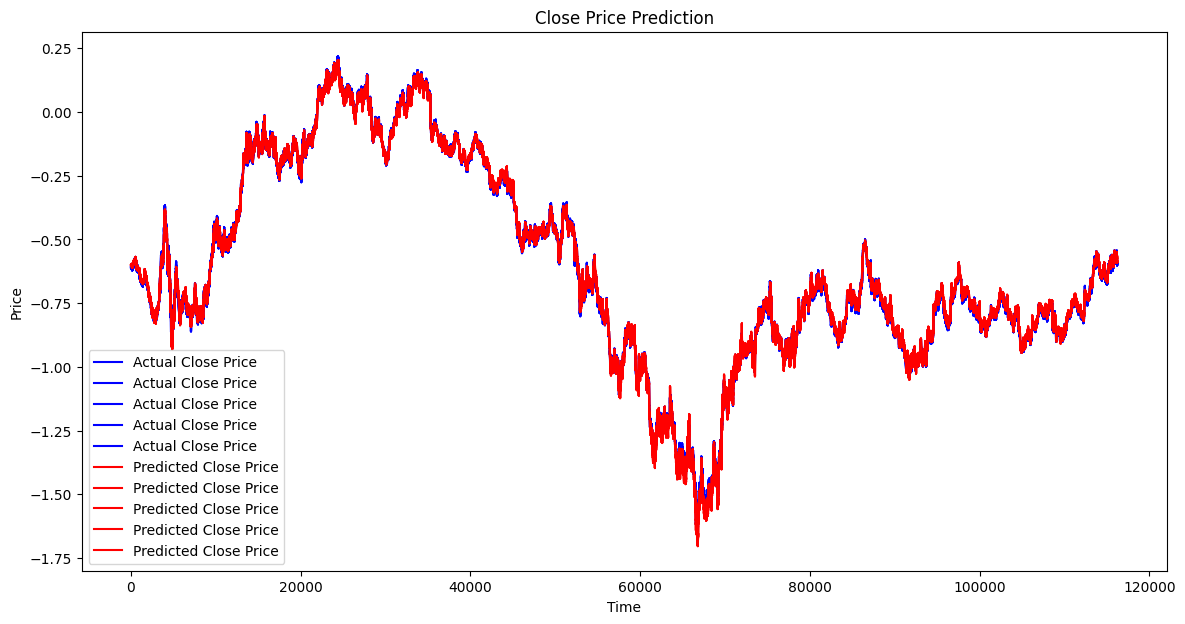

In [16]:
# load the model
# model = tf.keras.models.load_model('./lstm_model.h5')

# Predicting the closing price
predictions = model.predict(X_test)

# Evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plotting the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(y_test, color='blue', label='Actual Close Price')
plt.plot(predictions, color='red', label='Predicted Close Price')
plt.title('Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

3633/3633 ━━━━━━━━━━━━━━━━━━━━ 43s 12ms/step
Mean Squared Error: 0.0001011306972092537
Mean Absolute Error: 0.007177946218102301


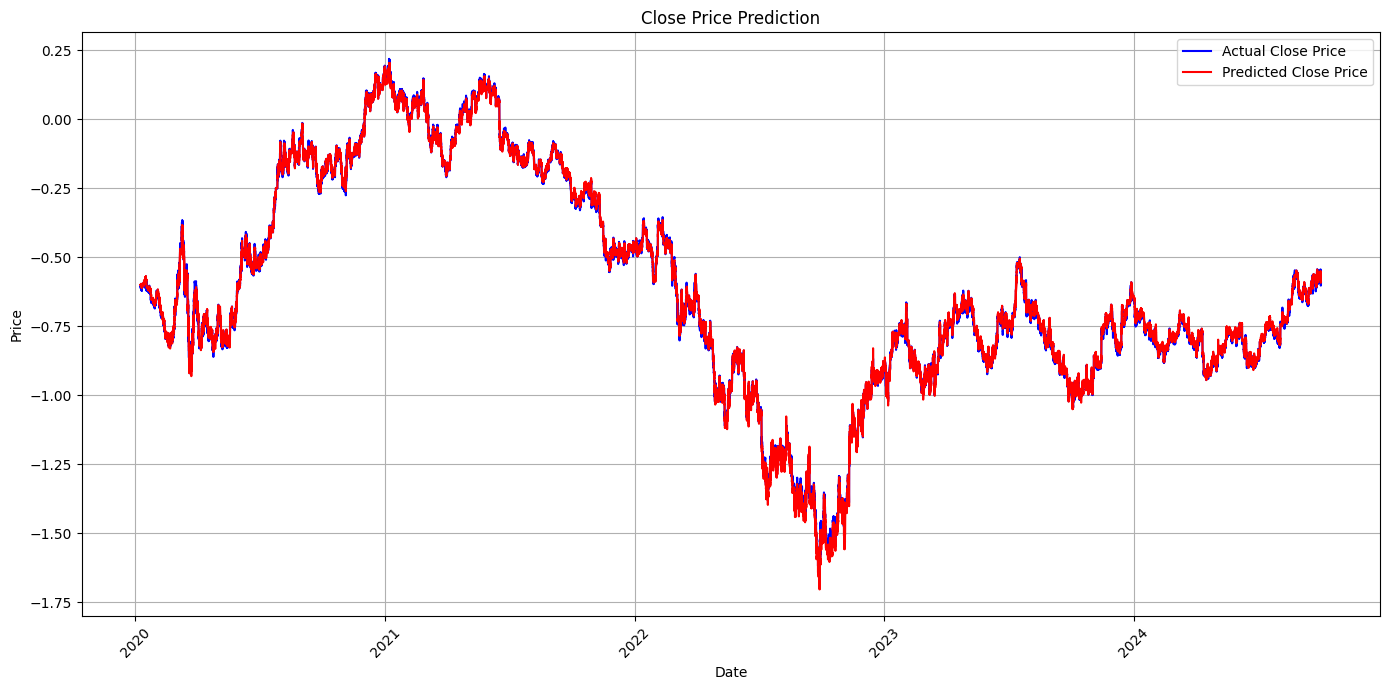

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Predicting the closing prices (next 5 candles)
predictions = model.predict(X_test)

# Evaluation
# Reshape y_test to match the predictions
y_test_reshaped = y_test.reshape(-1, y_test.shape[1])  # Ensure y_test has the same shape as predictions

# Calculate the mean for the predictions to evaluate single-step forecasts
predictions_mean = predictions.mean(axis=1)  # Take the mean of the 5 predictions
mse = mean_squared_error(y_test_reshaped[:, 0], predictions_mean)  # Compare with the first predicted step
mae = mean_absolute_error(y_test_reshaped[:, 0], predictions_mean)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Creating a DataFrame for easy plotting
predicted_dates = data.index[len(data) - len(y_test):]  # Get the corresponding timestamps for y_test

# Create a DataFrame for actual and predicted values
results_df = pd.DataFrame({
    'Actual': y_test_reshaped[:, 0],  # Use only the first column for actual values
    'Predicted': predictions_mean
}, index=predicted_dates)

# Plotting the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(results_df['Actual'], color='blue', label='Actual Close Price')
plt.plot(results_df['Predicted'], color='red', label='Predicted Close Price')
plt.title('Close Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)  # Rotate x-axis labels for better visibility
plt.grid()
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


In [18]:
results_df.head(30)

,Actual,Predicted
date,,
2020-01-08 22:45:00,-0.608544,-0.600565
2020-01-08 23:00:00,-0.611889,-0.600959
2020-01-08 23:15:00,-0.609213,-0.602604
2020-01-08 23:30:00,-0.607205,-0.601575
2020-01-08 23:45:00,-0.607205,-0.600192
2020-01-09 00:00:00,-0.607875,-0.599820
2020-01-09 00:15:00,-0.608544,-0.600592
2020-01-09 00:30:00,-0.607205,-0.601850
2020-01-09 00:45:00,-0.606537,-0.601718


In [19]:
def create_sequences(data, seq_length, prediction_length):
    xs, ys, timestamps = [], [], []
    for i in range(len(data) - seq_length - prediction_length):
        x = data.iloc[i:i + seq_length].values
        y = data.iloc[i + seq_length:i + seq_length + prediction_length]['Close'].values
        timestamp_seq = data.index[i:i + seq_length].to_list()  # Extract timestamps from the index
        xs.append(x)
        ys.append(y)
        timestamps.append(timestamp_seq)
    return np.array(xs), np.array(ys), timestamps

In [21]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
from datetime import datetime

class ForexBacktester:
    def __init__(self, model_path, initial_balance=10000, transaction_fee=0.0001, pred_length=5):
        self.model = load_model(model_path)
        self.initial_balance = initial_balance
        self.balance = initial_balance
        self.transaction_fee = transaction_fee
        self.pred_length = pred_length
        self.positions = []
        self.trades = []
        self.equity_curve = []
        self.predictions = []
        
    def normalize_data(self, data):
        # Implement the same normalization you used for training
        # Handling missing values using mean imputation
        imputer = SimpleImputer(strategy='mean')
        data_imputed = pd.DataFrame(imputer.fit_transform(data), columns=data.columns)

        # Normalizing data for LSTM model compatibility
        scaler = StandardScaler()
        data_normalized = pd.DataFrame(scaler.fit_transform(data_imputed), columns=data.columns)
        return data_normalized
    
    def create_sequence(self, data, seq_length, prediction_length=5):
        xs, ys, timestamps = [], [], []
        for i in range(len(data) - seq_length - prediction_length):
            x = data.iloc[i:i + seq_length].values
            y = data.iloc[i + seq_length:i + seq_length + prediction_length]['Close'].values
            timestamp_seq = data.index[i:i + seq_length].to_list()  # Extract timestamps from the index
            xs.append(x)
            ys.append(y)
            timestamps.append(timestamp_seq)
        return np.array(xs), np.array(ys), timestamps
    
    def predict_next_prices(self, sequence):
        prediction = self.model.predict(sequence.reshape(1, *sequence.shape), verbose=0)
        return prediction[0]  # Return the 5 predicted prices
    
    def execute_trade(self, current_price, predicted_prices, current_index, data):
        # More sophisticated trading logic using all 5 predicted prices
        price_changes = predicted_prices - current_price
        avg_price_change = np.mean(price_changes)
        max_price_change = np.max(price_changes)
        min_price_change = np.min(price_changes)
        
        # Store prediction for later analysis
        self.predictions.append({
            'time': current_index,
            'current_price': current_price,
            'predicted_prices': predicted_prices
        })
        
        # Trading logic
        if not self.positions:  # No position, look for entry
            if avg_price_change > 0 and max_price_change > current_price * 0.001:  # 0.1% potential gain
                position_size = self.balance * 0.1  # Use 10% of balance
                fee = position_size * self.transaction_fee
                self.balance -= fee
                self.positions.append({
                    'type': 'buy',
                    'size': position_size,
                    'entry_price': current_price,
                    'entry_time': current_index,
                    'target_prices': predicted_prices
                })
                self.trades.append({
                    'type': 'buy',
                    'price': current_price,
                    'fee': fee,
                    'time': current_index
                })
        else:  # Have position, look for exit
            position = self.positions[0]
            time_in_trade = current_index - position['entry_time']
            
            # Exit conditions:
            # 1. Predicted prices are lower than current price
            # 2. We've held for the full prediction length
            # 3. We've hit our target profit
            exit_trade = (avg_price_change < 0 or 
                         time_in_trade >= self.pred_length or 
                         current_price >= np.max(position['target_prices']))
            
            if exit_trade:
                position = self.positions.pop()
                exit_value = position['size'] * (current_price / position['entry_price'])
                fee = exit_value * self.transaction_fee
                profit = exit_value - position['size'] - fee
                self.balance += exit_value - fee
                self.trades.append({
                    'type': 'sell',
                    'price': current_price,
                    'profit': profit,
                    'time': current_index
                })
    
    def backtest(self, data, seq_length=50):
        normalized_data = self.normalize_data(data)
        sequences = self.create_sequence(normalized_data, seq_length)
        
        for i in range(len(sequences)):
            current_sequence = sequences[i]
            current_index = i + seq_length - 1
            current_price = data.iloc[current_index]['Close']
            
            predicted_prices = self.predict_next_prices(current_sequence)
            
            # Denormalize predictions
            denorm_predictions = predicted_prices * normalized_data.std() + normalized_data.mean()
            
            self.execute_trade(current_price, denorm_predictions, current_index, data)
            
            # Calculate current equity (balance + open positions)
            current_equity = self.balance
            for position in self.positions:
                current_equity += position['size'] * (current_price / position['entry_price'])
            self.equity_curve.append(current_equity)
    
    def get_performance_metrics(self):
        returns = np.array(self.equity_curve) / self.initial_balance - 1
        
        # Calculate prediction accuracy
        correct_predictions = 0
        total_predictions = len(self.predictions)
        
        for i, pred in enumerate(self.predictions[:-self.pred_length]):  # Skip last few predictions that we can't verify
            actual_prices = [self.predictions[j]['current_price'] for j in range(i+1, i+1+self.pred_length)]
            predicted_direction = np.mean(pred['predicted_prices']) > pred['current_price']
            actual_direction = np.mean(actual_prices) > pred['current_price']
            if predicted_direction == actual_direction:
                correct_predictions += 1
        
        prediction_accuracy = correct_predictions / (total_predictions - self.pred_length) if total_predictions > self.pred_length else 0
        
        metrics = {
            'Final Balance': self.balance,
            'Return': (self.balance / self.initial_balance - 1) * 100,
            'Max Drawdown': self.calculate_max_drawdown() * 100,
            'Sharpe Ratio': self.calculate_sharpe_ratio(returns),
            'Total Trades': len(self.trades),
            'Win Rate': self.calculate_win_rate(),
            'Prediction Accuracy': prediction_accuracy * 100
        }
        return metrics
    
    def calculate_max_drawdown(self):
        peak = self.equity_curve[0]
        max_drawdown = 0
        
        for equity in self.equity_curve:
            if equity > peak:
                peak = equity
            drawdown = (peak - equity) / peak
            max_drawdown = max(max_drawdown, drawdown)
        
        return max_drawdown
    
    def calculate_sharpe_ratio(self, returns, risk_free_rate=0.01):
        excess_returns = returns - risk_free_rate / 252  # Assuming daily data
        return np.sqrt(252) * np.mean(excess_returns) / np.std(excess_returns) if np.std(excess_returns) != 0 else 0
    
    def calculate_win_rate(self):
        profitable_trades = sum(1 for trade in self.trades if trade.get('profit', 0) > 0)
        return profitable_trades / len(self.trades) if self.trades else 0
    
    def plot_results(self):
        fig = plt.figure(figsize=(15, 15))
        
        # Equity Curve
        ax1 = fig.add_subplot(311)
        ax1.plot(self.equity_curve)
        ax1.set_title('Equity Curve')
        ax1.set_xlabel('Time')
        ax1.set_ylabel('Equity')
        
        # Returns Distribution
        ax2 = fig.add_subplot(312)
        returns = np.diff(self.equity_curve) / self.equity_curve[:-1]
        ax2.hist(returns, bins=50)
        ax2.set_title('Distribution of Returns')
        ax2.set_xlabel('Return')
        ax2.set_ylabel('Frequency')
        
        # Prediction Accuracy Over Time
        ax3 = fig.add_subplot(313)
        accuracies = []
        window = 100  # Calculate accuracy over rolling window
        for i in range(len(self.predictions) - self.pred_length):
            if i < window:
                continue
            correct = 0
            for j in range(i-window, i):
                pred = self.predictions[j]
                actual_prices = [self.predictions[k]['current_price'] for k in range(j+1, j+1+self.pred_length)]
                if len(actual_prices) < self.pred_length:
                    break
                predicted_direction = np.mean(pred['predicted_prices']) > pred['current_price']
                actual_direction = np.mean(actual_prices) > pred['current_price']
                if predicted_direction == actual_direction:
                    correct += 1
            accuracies.append(correct/window)
        
        ax3.plot(accuracies)
        ax3.set_title(f'Prediction Accuracy (Rolling {window} periods)')
        ax3.set_xlabel('Time')
        ax3.set_ylabel('Accuracy')
        
        plt.tight_layout()
        plt.show()

# Example usage
def run_backtest(data_path, model_path):
    data = pd.read_csv(data_path)
    backtester = ForexBacktester(model_path, pred_length=5)
    backtester.backtest(data)
    
    metrics = backtester.get_performance_metrics()
    for metric, value in metrics.items():
        print(f"{metric}: {value:.2f}")
    
    backtester.plot_results()

if __name__ == "__main__":
    run_backtest("cleaned_EURUSD_M15.csv", "lstm_model.h5")

TypeError: Could not locate function 'mse'. Make sure custom classes are decorated with `@keras.saving.register_keras_serializable()`. Full object config: {'module': 'keras.metrics', 'class_name': 'function', 'config': 'mse', 'registered_name': 'mse'}

In [ ]:
# load the saved model
model = tf.keras.models.load_model('lstm_model.h5')
model_predictions = model.predict(X_test)  # Make predictions

# Initialize variables
balance = 10000  # Starting balance
positions = []  # Track open positions (store entry price, size, and direction)
trading_fee = 0.001  # Example trading fee (0.1%)
profit_target = 1.015  # 1.5% profit target for long positions
stop_loss = 0.99  # 1% stop loss for long positions
short_profit_target = 0.985  # 1.5% profit target for short positions
short_stop_loss = 1.01  # 1% stop loss for short positions

# Paper trading simulation
for i in range(len(model_predictions)):
    current_price = data['Close'].iloc[i + SEQ_LENGTH - 1]
    predicted_closes = model_predictions[i]  # Predicted close prices for the next 5 candles

    # Check if we have any open positions
    if positions:
        for position in positions[:]:  # Create a copy of the list to avoid mutation issues
            entry_price = position['entry_price']
            size = position['size']
            direction = position['direction']

            # Check if we should sell based on profit target or stop loss
            if direction == 'long':
                if (current_price >= entry_price * profit_target) or (current_price <= entry_price * stop_loss):
                    # Calculate exit
                    balance += size * current_price * (1 - trading_fee)
                    positions.remove(position)  # Remove closed position
                    print(f"Closed Long: Entry Price: {entry_price}, Exit Price: {current_price}, New Balance: {balance}")

            elif direction == 'short':
                if (current_price <= entry_price * short_profit_target) or (current_price >= entry_price * short_stop_loss):
                    # Calculate exit
                    balance += size * (entry_price - current_price) * (1 - trading_fee)
                    positions.remove(position)  # Remove closed position
                    print(f"Closed Short: Entry Price: {entry_price}, Exit Price: {current_price}, New Balance: {balance}")

    # Long position entry condition
    if np.mean(predicted_closes) > current_price * 1.01:  # Average predicted close should exceed current price by 1%
        # Buy logic (Long)
        size = balance * 0.1 / current_price  # Using 10% of balance to buy
        positions.append({'entry_price': current_price, 'size': size, 'direction': 'long'})
        balance -= size * current_price * (1 + trading_fee)
        print(f"Opened Long: Entry Price: {current_price}, Size: {size}, New Balance: {balance}")

    # Short position entry condition
    elif np.mean(predicted_closes) < current_price * 0.99:  # Average predicted close should be below current price by 1%
        # Sell logic (Short)
        size = balance * 0.1 / current_price  # Using 10% of balance to short
        positions.append({'entry_price': current_price, 'size': size, 'direction': 'short'})
        balance += size * current_price * (1 - trading_fee)  # Sell the asset for the current price
        print(f"Opened Short: Entry Price: {current_price}, Size: {size}, New Balance: {balance}")

# Final balance
print(f"Final Balance: {balance}")


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Assuming predictions and y_test are numpy arrays or pandas Series
predictions = model.predict(X_test).flatten()
actual_prices = y_test

# Create a DataFrame to store results
results = pd.DataFrame({
    'Actual': actual_prices,
    'Predicted': predictions
})

# Define trading strategy: Long if predicted price > actual price, short if predicted price < actual price
results['Signal'] = np.where(results['Predicted'] > results['Actual'], 1, -1)

# Calculate returns: If long, return is (next day's price - current price), if short, return is (current price - next day's price)
results['Return'] = results['Signal'] * (results['Actual'].shift(-1) - results['Actual'])

# Drop the last row with NaN return
results = results[:-1]

# Calculate cumulative returns
results['Cumulative Return'] = results['Return'].cumsum()

# Calculate drawdown
results['Cumulative Max'] = results['Cumulative Return'].cummax()
results['Drawdown'] = results['Cumulative Max'] - results['Cumulative Return']

# Calculate Sharpe Ratio
mean_return = results['Return'].mean()
std_return = results['Return'].std()
sharpe_ratio = mean_return / std_return * np.sqrt(252)  # 252 trading days in a year

# Calculate win rate
results['Win'] = results['Return'] > 0
win_rate = results['Win'].mean()

# Calculate number of losses
losses = len(results[results['Return'] < 0])

# Metrics
mse = mean_squared_error(actual_prices, predictions)
mae = mean_absolute_error(actual_prices, predictions)
max_drawdown = results['Drawdown'].max()

# Print metrics
print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')
print(f'Sharpe Ratio: {sharpe_ratio}')
print(f'Win Rate: {win_rate}')
print(f'Total Losses: {losses}')
print(f'Max Drawdown: {max_drawdown}')

# Plotting the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(actual_prices, color='blue', label='Actual Close Price')
plt.plot(predictions, color='red', label='Predicted Close Price')
plt.title('Close Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plotting cumulative returns and drawdown
plt.figure(figsize=(14, 7))
plt.plot(results['Cumulative Return'], color='green', label='Cumulative Return')
plt.plot(results['Drawdown'], color='red', label='Drawdown')
plt.title('Backtesting Results')
plt.xlabel('Time')
plt.ylabel('Returns / Drawdown')
plt.legend()
plt.show()


In [ ]:
predictions.shape

In [ ]:
y_test.shape

In [ ]:

# Evaluation
mse = mean_squared_error(y_test, predictions)
mae = mean_absolute_error(y_test, predictions)

print(f'Mean Squared Error: {mse}')
print(f'Mean Absolute Error: {mae}')

# Plotting the predictions vs actual values
plt.figure(figsize=(14, 5))
plt.plot(y_test, color='blue', label='Actual Prices')
plt.plot(predictions, color='red', label='Predicted Prices')
plt.title('Forex Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [19]:
class ForexEnv(gym.Env):
    def __init__(self, df, seq_length, model):
        super(ForexEnv, self).__init__()
        self.df = df
        self.seq_length = seq_length
        self.model = model
        self.current_step = seq_length
        self.balance = 10000
        self.positions = []
        self.done = False
        self.initial_balance = 10000
        self.trading_fee = 0.001  # Example fee of 0.1%
        self.max_positions = 5

        self.action_space = gym.spaces.Discrete(3)  # Hold, Buy, Sell
        self.observation_space = gym.spaces.Box(low=-1, high=1, shape=(seq_length, df.shape[1]), dtype=np.float32)

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.seq_length
        self.balance = self.initial_balance
        self.positions = []
        self.done = False
        return self._next_observation(), {}

    def _next_observation(self):
        obs = self.df.iloc[self.current_step - self.seq_length:self.current_step].values
        return obs

    def step(self, action):
        current_price = self.df['Close'].iloc[self.current_step]
        truncated = False 
        # Execute action
        if action == 1:  # Buy
            self.positions.append(current_price)
        elif action == 2 and self.positions:  # Sell
            buy_price = self.positions.pop(0)
            self.balance += current_price - buy_price

        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            self.done = True

        obs = self._next_observation()
        reward = self.balance
        return obs, reward, self.done, truncated, {}
    
    def _get_unrealized_profit(self):
        unrealized_profit = 0
        current_price = self.df['Close'].iloc[self.current_step]
        for position in self.positions:
            if position['type'] == 'buy':
                unrealized_profit += current_price - position['price']
            elif position['type'] == 'sell':
                unrealized_profit += position['price'] - current_price
        return unrealized_profit

    def _place_limit_order(self, order_type, limit_price):
        """Place a limit order to buy or sell."""
        if order_type == 'buy':
            self.positions.append({'type': 'buy', 'price': limit_price, 'limit': True})
        elif order_type == 'sell':
            self.positions.append({'type': 'sell', 'price': limit_price, 'limit': True})
    
    def _set_stop_loss(self, stop_loss_price):
        """Set a stop-loss price for open positions."""
        for position in self.positions:
            if 'stop_loss' not in position:
                position['stop_loss'] = stop_loss_price
    
    def _set_take_profit(self, take_profit_price):
        """Set a take-profit price for open positions."""
        for position in self.positions:
            if 'take_profit' not in position:
                position['take_profit'] = take_profit_price

    def _execute_limit_orders(self):
        """Check if any limit orders can be executed."""
        current_price = self.df['Close'].iloc[self.current_step]
        for position in self.positions:
            if position['limit']:
                if position['type'] == 'buy' and current_price <= position['price']:
                    position['limit'] = False
                    self.balance -= current_price * (1 + self.trading_fee)
                elif position['type'] == 'sell' and current_price >= position['price']:
                    position['limit'] = False
                    self.balance += current_price * (1 - self.trading_fee)
                    self.positions.remove(position)

    def _check_stop_loss_take_profit(self):
        """Check if stop-loss or take-profit conditions are met for open positions."""
        current_price = self.df['Close'].iloc[self.current_step]
        for position in self.positions:
            if 'stop_loss' in position and current_price <= position['stop_loss']:
                if position['type'] == 'buy':
                    self.balance += position['stop_loss'] * (1 - self.trading_fee)
                    self.positions.remove(position)
            elif 'take_profit' in position and current_price >= position['take_profit']:
                if position['type'] == 'buy':
                    self.balance += position['take_profit'] * (1 - self.trading_fee)
                    self.positions.remove(position)
        
    def render(self, mode='human'):
        if self.render_mode == 'human':
            # Add custom rendering code here
            print(f"Step: {self.current_step}, Balance: {self.balance}, Positions: {self.positions}")


In [20]:
def make_env():
    return ForexEnv(data_normalized, SEQ_LENGTH, model)

In [ ]:
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
# Number of parallel environments
num_envs = 1

# Create a list of environment creation functions
env_fns = [make_env for _ in range(num_envs)]

# Create the vectorized environment
# env = SubprocVecEnv(env_fns)
# Create the environment
env = DummyVecEnv([lambda: ForexEnv(data_normalized, SEQ_LENGTH, model)])

# Train the DQN agent
dqn_model = DQN(
    'MlpPolicy', 
    env, 
    verbose=1,
    learning_rate=0.001,  # Slightly lower learning rate for stability
    gamma=0.99,           # Higher discount factor to consider future rewards more
    batch_size=64,        # Keep as is, but can experiment with 32 or 128
    train_freq=4,         # How often to train the model
    target_update_interval=10000, # Update the target network every 10000 steps
    exploration_fraction=0.1,     # Fraction of total training timesteps over which the exploration rate is annealed
    exploration_final_eps=0.02,   # Final value of random action probability
    buffer_size=100000,           # Size of the replay buffer
    learning_starts=1000,         # Number of steps before learning starts
    max_grad_norm=0.5             # Max gradient norm for gradient clipping
)

checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./models/', name_prefix='ppo_forex')
eval_env = DummyVecEnv([lambda: ForexEnv(data_normalized, SEQ_LENGTH, model)])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/', log_path='./logs/', eval_freq=5000, deterministic=True)

# List of callbacks
callback = CallbackList([checkpoint_callback, eval_callback])

# Train the model
dqn_model.learn(total_timesteps=500000, callback=callback)


In [ ]:
# Save the model
dqn_model.save("dqn_forex_model")

# Load the model
dqn_model = DQN.load("dqn_forex_model")

# Evaluate the model
obs = env.reset()
for i in range(1000):
    action, _states = dqn_model.predict(obs)
    obs, rewards, dones, info = env.step(action)
    env.render()

In [ ]:
# Save the model
dqn_model.save("dqn_forex_trading")

In [ ]:
del dqn_model
# Load the model
dqn_model = DQN.load("dqn_forex_trading")

# Evaluate the model
obs = env.reset()
for i in range(len(data_normalized) - SEQ_LENGTH):
    action, _ = dqn_model.predict(obs)
    obs, reward, done, _ = env.step(action)
    print(f"Step {i}:")
    print(f"    Action: {action}")
    print(f"    Reward: {reward}")
    print(f"    Balance: {env.envs[0].unwrapped.balance}")
    if done:
        break

env.render()

In [ ]:
class ForexEnv(gym.Env):
    def __init__(self, df, seq_length, model):
        super(ForexEnv, self).__init__()
        self.df = df
        self.seq_length = seq_length
        self.model = model
        self.current_step = seq_length
        self.balance = 10000
        self.positions = []
        self.done = False
        self.initial_balance = 10000
        self.trading_fee = 0.001  # Example fee of 0.1%
        self.max_positions = 5

        # Define action space: Hold, Buy Market, Sell Market, Buy Limit, Sell Limit, Set Stop-Loss, Set Take-Profit
        self.action_space = spaces.Discrete(7)
        
        # Update observation space to include more relevant features
        self.observation_space = spaces.Box(low=-1, high=1, shape=(seq_length * df.shape[1] + 4,), dtype=np.float32)
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.current_step = self.seq_length
        self.balance = self.initial_balance
        self.positions = []
        self.done = False
        return self._next_observation(), {}

    def _next_observation(self):
        obs = self.df.iloc[self.current_step - self.seq_length:self.current_step].values
        
        # Add balance and position information to observation
        balance_obs = np.array([self.balance])
        positions_obs = np.array([len(self.positions), sum([p['price'] for p in self.positions]), self._get_unrealized_profit()])
        return np.concatenate((obs.flatten(), balance_obs, positions_obs))

    def _get_unrealized_profit(self):
        unrealized_profit = 0
        current_price = self.df['Close'].iloc[self.current_step]
        for position in self.positions:
            if position['type'] == 'buy':
                unrealized_profit += current_price - position['price']
            elif position['type'] == 'sell':
                unrealized_profit += position['price'] - current_price
        return unrealized_profit

    def step(self, action):
        current_price = self.df['Close'].iloc[self.current_step]
        truncated = False
        reward = 0

        if action == 1:  # Buy Market
            if len(self.positions) < self.max_positions:
                self.positions.append({'type': 'buy', 'price': current_price})
                self.balance -= current_price * (1 + self.trading_fee)
        
        elif action == 2:  # Sell Market
            if len(self.positions) > 0:
                position = self.positions.pop(0)
                if position['type'] == 'buy':
                    reward += current_price - position['price']
                self.balance += current_price * (1 - self.trading_fee)

        elif action == 3:  # Buy Limit
            self._place_limit_order('buy', current_price - 0.01)  # Example limit price
        
        elif action == 4:  # Sell Limit
            self._place_limit_order('sell', current_price + 0.01)  # Example limit price
        
        elif action == 5:  # Set Stop-Loss
            self._set_stop_loss(current_price - 0.02)  # Example stop-loss price
        
        elif action == 6:  # Set Take-Profit
            self._set_take_profit(current_price + 0.02)  # Example take-profit price
        
        # Update reward based on balance changes
        reward += self.balance - self.initial_balance
        
        self.current_step += 1
        if self.current_step >= len(self.df) - 1:
            self.done = True

        obs = self._next_observation()
        return obs, reward, self.done, truncated, {}

    def _place_limit_order(self, order_type, limit_price):
        """Place a limit order to buy or sell."""
        if order_type == 'buy':
            self.positions.append({'type': 'buy', 'price': limit_price, 'limit': True})
        elif order_type == 'sell':
            self.positions.append({'type': 'sell', 'price': limit_price, 'limit': True})
    
    def _set_stop_loss(self, stop_loss_price):
        """Set a stop-loss price for open positions."""
        for position in self.positions:
            if 'stop_loss' not in position:
                position['stop_loss'] = stop_loss_price
    
    def _set_take_profit(self, take_profit_price):
        """Set a take-profit price for open positions."""
        for position in self.positions:
            if 'take_profit' not in position:
                position['take_profit'] = take_profit_price

    def _execute_limit_orders(self):
        """Check if any limit orders can be executed."""
        current_price = self.df['Close'].iloc[self.current_step]
        for position in self.positions:
            if position['limit']:
                if position['type'] == 'buy' and current_price <= position['price']:
                    position['limit'] = False
                    self.balance -= current_price * (1 + self.trading_fee)
                elif position['type'] == 'sell' and current_price >= position['price']:
                    position['limit'] = False
                    self.balance += current_price * (1 - self.trading_fee)
                    self.positions.remove(position)

    def _check_stop_loss_take_profit(self):
        """Check if stop-loss or take-profit conditions are met for open positions."""
        current_price = self.df['Close'].iloc[self.current_step]
        for position in self.positions:
            if 'stop_loss' in position and current_price <= position['stop_loss']:
                if position['type'] == 'buy':
                    self.balance += position['stop_loss'] * (1 - self.trading_fee)
                    self.positions.remove(position)
            elif 'take_profit' in position and current_price >= position['take_profit']:
                if position['type'] == 'buy':
                    self.balance += position['take_profit'] * (1 - self.trading_fee)
                    self.positions.remove(position)

In [ ]:
# Create the environment
env = DummyVecEnv([lambda: ForexEnv(data_normalized, SEQ_LENGTH, model)])

# Train the DQN agent
dqn_model = DQN('MlpPolicy', env, verbose=1)
dqn_model.learn(total_timesteps=100000)

In [ ]:
# Save the model
dqn_model.save("dqn_forex_trading01")

In [ ]:
del dqn_model
# Load the model
dqn_model = DQN.load("dqn_forex_trading01")

# Evaluate the model
obs = env.reset()
for i in range(len(data_normalized) - SEQ_LENGTH):
    action, _ = dqn_model.predict(obs)
    obs, reward, done, _ = env.step(action)
    print(f"Step {i}:")
    print(f"    Action: {action}")
    print(f"    Reward: {reward}")
    print(f"    Balance: {env.envs[0].unwrapped.balance}")
    if done:
        break

env.render()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d45628e-a0f9-421e-94f2-273c0d2863ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>